We’ll use one table for all symbols — simpler for queries & backtesting.



## New Workflow:
1. Write multiple ASX tickers into a single CSV
2. Save CSV to sqlite and work around the pk constraint to allow loading same file to update any new items and overwrite any existing

Why this format is ideal

✔ One file
✔ Multiple stocks
✔ Easy import into SQLite / Pandas / Excel
✔ Perfect for backtesting & journaling

In [103]:
'''
Why this works

df["date"].dt.strftime("%Y-%m-%d") → converts Timestamp to plain string "2024-01-02"

SQLite is happy with strings for DATE columns

INSERT OR IGNORE skips duplicates (primary key enforcement)

'''

import yfinance as yf
import pandas as pd

# done 2015-1-1 to 2026-1-1

# TICKERS = ["BHP.AX", "CBA.AX", "CSL.AX", "WES.AX", "VAS.AX", "A200.AX","VAP.AX","VHY.AX","NDQ.AX","SPY.AX","BOE.AX", "STW.AX","ASX.AX"]

# Update a single stock
TICKERS = ["ASX.AX"]

all_data = []

for ticker in TICKERS:
    df = yf.download(
        ticker,
        start="2015-01-01",
        auto_adjust=True,
        progress=False
    )

    if df.empty:
        continue

    df.reset_index(inplace=True)
    df["symbol"] = ticker

    df = df[["symbol", "Date", "Open", "High", "Low", "Close", "Volume"]]
    df.columns = ["symbol", "date", "open", "high", "low", "close", "volume"]

    all_data.append(df)

# Combine all tickers into one DataFrame
final_df = pd.concat(all_data, ignore_index=True)

# Write to single CSV
final_df.to_csv("asx_all_prices.csv", index=False)

# remove duplicates:
df.drop_duplicates(subset=["symbol", "date"], inplace=True)

print("Saved asx_all_prices.csv")


Saved asx_all_prices.csv


# Optional upgrades (recommended)
## Sort nicely

In [104]:
final_df.to_csv("asx_all_prices.csv", mode="a", header=False, index=False)

In [105]:
# Add daily return:

final_df["daily_return"] = final_df.groupby("symbol")["close"].pct_change()*100

# chekc dataframe:

final_df

,symbol,date,open,high,low,close,volume,daily_return
0,ASX.AX,2015-01-02,24.722970,24.722970,24.388695,24.582575,173997,NaN
1,ASX.AX,2015-01-05,24.569204,24.729657,24.522405,24.709599,280305,0.516723
2,ASX.AX,2015-01-06,24.475603,24.569199,24.194811,24.341892,435167,-1.488111
3,ASX.AX,2015-01-07,24.261664,24.428801,24.201494,24.368631,421898,0.109848
4,ASX.AX,2015-01-08,24.636057,24.709598,24.462235,24.535776,309909,0.685901
...,...,...,...,...,...,...,...,...
2800,ASX.AX,2026-01-23,53.849998,54.230000,53.720001,53.820000,404435,-0.018581
2801,ASX.AX,2026-01-27,53.820000,54.389999,53.529999,53.639999,553798,-0.334449
2802,ASX.AX,2026-01-28,53.029999,54.500000,52.230000,53.480000,796130,-0.298285
2803,ASX.AX,2026-01-29,54.270000,57.470001,54.075001,57.470001,1438675,7.460736


In [106]:
# read out the csv
df = pd.read_csv("asx_all_prices.csv")
df["daily_return"] = df.groupby("symbol")["close"].pct_change()*100# Write to single CSV

print(df.tail(20))

      symbol        date       open       high        low      close   volume  \
5590  ASX.AX  2026-01-02  51.500000  51.700001  51.410000  51.410000   252826   
5591  ASX.AX  2026-01-05  51.279999  51.500000  50.810001  50.840000   423858   
5592  ASX.AX  2026-01-06  50.919998  50.970001  50.529999  50.529999   658087   
5593  ASX.AX  2026-01-07  50.000000  51.349998  49.985001  51.119999  1168901   
5594  ASX.AX  2026-01-08  51.669998  52.330002  51.410000  52.139999  1096718   
5595  ASX.AX  2026-01-09  52.740002  52.930000  52.299999  52.389999   933586   
5596  ASX.AX  2026-01-12  52.349998  52.880001  52.009998  52.799999   584795   
5597  ASX.AX  2026-01-13  53.040001  53.230000  52.730000  52.730000   732779   
5598  ASX.AX  2026-01-14  52.490002  52.830002  52.240002  52.490002   518236   
5599  ASX.AX  2026-01-15  52.660000  52.810001  52.220001  52.380001   392415   
5600  ASX.AX  2026-01-16  52.070000  52.490002  51.720001  52.490002   859928   
5601  ASX.AX  2026-01-19  52

# CSV to sqlite

# can't use df.to.sql() to insert as it will enforce pk, which in turn prevent update overriding existing data when add new data

Perfect — this is a very common + sensible pipeline:

Yahoo → one CSV → SQLite

Below is a clean, safe implementation that:

Reads the single CSV

Inserts into your existing prices table

Avoids duplicates

Matches the schema exactly

In [107]:
import pandas as pd
import sqlite3

# Read CSV
df = pd.read_csv("asx_all_prices.csv", parse_dates=["date"])

# Convert datetime to string in YYYY-MM-DD format
df["date"] = df["date"].dt.strftime("%Y-%m-%d")

# Connect to SQLite
conn = sqlite3.connect("asx_prices.db")

# create table if not exits
conn.execute("""
        CREATE TABLE IF NOT EXISTS prices (
            symbol TEXT NOT NULL,
            date   DATE NOT NULL,
            open   REAL,
            high   REAL,
            low    REAL,
            close  REAL,
            volume INTEGER,
            PRIMARY KEY (symbol, date)
        )
    """)


cursor = conn.cursor()

# Insert rows safely, ignoring duplicates
cursor.executemany("""
    INSERT OR IGNORE INTO prices
    (symbol, date, open, high, low, close, volume)
    VALUES (?, ?, ?, ?, ?, ?, ?)
""", df.itertuples(index=False, name=None))

conn.commit()
conn.close()

print("CSV loaded into SQLite successfully!")


CSV loaded into SQLite successfully!


In [4]:
# Quick sanity check
import sqlite3
import pandas as pd

conn = sqlite3.connect("asx_prices.db")

pd.read_sql("""
    SELECT symbol, COUNT(*) rows
    FROM prices
    GROUP BY symbol
""", conn)

,symbol,rows
0,A200.AX,1959
1,ASX.AX,2805
2,BHP.AX,2805
3,BOE.AX,2805
4,CBA.AX,2805
5,CSL.AX,2805
6,NDQ.AX,2705
7,SPY.AX,2801
8,STW.AX,2804
9,VAP.AX,2803


Here’s the clean, correct SQLite query for a date range + specific ticker, plus a Pandas-friendly version since you’re using Python.

In [2]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("asx_prices.db")

# filter parameters:

ticker = "ASX.AX"
start  = "2019-01-01"
end    = "2025-01-12"

# query with parameter

df = pd.read_sql(
    """
    SELECT date, symbol, open, high, low, close, volume
    FROM prices
    WHERE symbol = ?
      AND date BETWEEN ? AND ?
    ORDER BY date
    """,
    conn,
    params=(ticker, start, end),
    parse_dates=["date"]
)

conn.close()

# post query processing - calculating returns
df["daily_return"] = df.groupby("symbol")["close"].pct_change()*100  


print(df.head(30))


         date  symbol       open       high        low      close  volume  \
0  2019-01-02  ASX.AX  46.864828  47.534214  46.864828  46.919956  211005   
1  2019-01-03  ASX.AX  47.479095  48.337483  47.195590  48.116978  324090   
2  2019-01-04  ASX.AX  47.392464  48.014599  47.266462  47.778343  268570   
3  2019-01-07  ASX.AX  48.290224  48.809982  48.172096  48.431976  268546   
4  2019-01-08  ASX.AX  48.179980  48.802115  48.038227  48.683987  241494   
5  2019-01-09  ASX.AX  48.321732  48.817866  48.053978  48.715488  261552   
6  2019-01-10  ASX.AX  49.132865  49.195867  48.400478  48.998989  350686   
7  2019-01-11  ASX.AX  49.061987  49.325802  48.857235  48.857235  179783   
8  2019-01-14  ASX.AX  49.148620  49.345498  48.857241  49.069870  174723   
9  2019-01-15  ASX.AX  48.904484  49.518745  48.904484  49.487244  224610   
10 2019-01-16  ASX.AX  49.306119  49.699875  49.148616  49.699875  360946   
11 2019-01-17  ASX.AX  49.959757  50.180263  49.621127  49.833755  262822   

In [ ]:
# add  Here’s a simple, correct histogram using matplotlib to show the distribution of df["daily_return"].

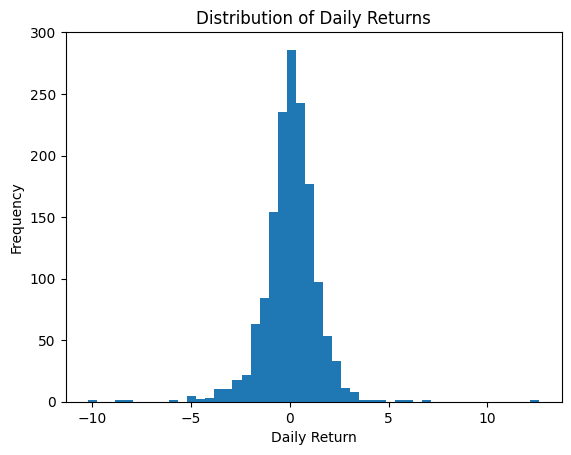

In [3]:
import matplotlib.pyplot as plt

# Drop NaNs (first return is always NaN)
returns = df["daily_return"].dropna()

plt.figure()
plt.hist(returns, bins=50)
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.title("Distribution of Daily Returns")

plt.show()


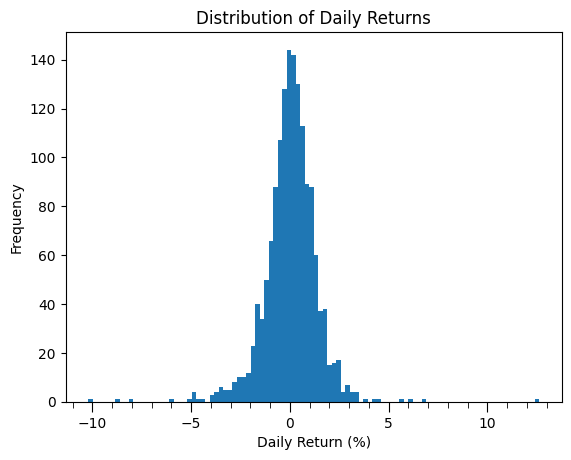

In [4]:
# Histogram with 1% minor ticks on daily return axis
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

returns = df["daily_return"].dropna()

plt.figure()
# plt.hist(returns * 100, bins=50)  # convert to %
plt.hist(returns, bins=100)  # convert to %

plt.xlabel("Daily Return (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Daily Returns")

ax = plt.gca()

# Major ticks every 5%
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))

# Minor ticks every 1%
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

# Show minor ticks
ax.tick_params(axis="x", which="minor", length=4)
ax.tick_params(axis="x", which="major", length=7)

plt.show()

In [ ]:
# Plotly histogram (zoomable)
import plotly.express as px

# Daily returns in %
returns = df["daily_return"].dropna() * 100

fig = px.histogram(
    returns,
    nbins=50,
    labels={"value": "Daily Return (%)"},
    title="Distribution of Daily Returns"
)

# 1% minor ticks equivalent (visual)
fig.update_xaxes(
    tickmode="linear",
    tick0=0,
    dtick=1
)

fig.update_yaxes(title="Frequency")

fig.show()


''' 



'''

' \n\nWhat you get automatically\n\n✔ Zoom with mouse drag\n✔ Pan & box select\n✔ Hover shows exact bin range & count\n✔ Double-click to reset zoom\n\n'